#INTRODUCTION
Here i will try to make a combined model from two papers
1. **[HINT](https://arxiv.org/abs/2402.14185)(High quality image inpainting transformer with masked aware attention and enhanced attention)**
2. **[YONOCS](https://arxiv.org/abs/2402.05809)(You only need one color space)**


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from pathlib import Path
import shutil
from PIL import Image

In [2]:
!pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 491.2 kB/s eta 0:00:00


#PREPARNIG DATA

In [3]:
import torchvision

train = torchvision.datasets.Places365(root = "data/", split = 'val', small = True, download = True)
train

100%|██████████| 67498496/67498496 [00:01<00:00, 56010953.29it/s]


Extracting data/filelist_places365-standard.tar to data/


100%|██████████| 525158400/525158400 [00:08<00:00, 61583980.32it/s]


Extracting data/val_256.tar to data/


Dataset Places365
    Number of datapoints: 36500
    Root location: data/
    Split: val
    Small: True

In [4]:
path = Path("data/val_256/")

# if we will use train data then it would have folders many of diff objects while in validation set there is no such complicaion
# removing the improper images
count = 0
for i in os.listdir(path):
  img = plt.imread(path/i)
  if img.shape[-1] != 3:
    os.remove(path/i)
    count += 1

print(f"Deleted images with incorrect number of dims : {count}")

Deleted images with incorrect number of dims : 79


In [5]:
# make the dataset but before try how to make the mask for the images
import numpy as np
from numpy.random import uniform

marg = 10
p_irr = 0.5 # probability of a polygonal chain mask
min_n_irr = 3
max_n_irr = 5
max_l_irr = 200
max_w_irr = 150

min_n_box = 3
max_n_box = 5
min_s_box = 50
max_s_box = 150

def gen_large_mask(img_h, img_w, n):

  """ img_h: int, an image height
  img_w: int, an image width
  marg: int, a margin for a box starting coordinate
  p_irr: float, 0 <= p_irr <= 1, a probability of a polygonal chain mask

  min_n_irr: int, min number of segments
  max_n_irr: int, max number of segments
  max_l_irr: max length of a segment in polygonal chain
  max_w_irr: max width of a segment in polygonal chain

  min_n_box: int, min bound for the number of box primitives
  max_n_box: int, max bound for the number of box primitives
  min_s_box: int, min length of a box side
  max_s_box: int, max length of a box side"""

  mask = ones((img_h, img_w))

  if np.random.uniform(0,1) < p_irr: # generate polygonal chain
    n = uniform(min_n_irr, max_n_irr) # sample number of segments

  for _ in range(int(n)):
    y = uniform(0, img_h) # sample a starting point
    x = uniform(0, img_w)

    a = uniform(0, 360) # sample angle
    l = uniform(10, max_l_irr) # sample segment length
    w = uniform(5, max_w_irr) # sample a segment width

    # draw segment starting from (x,y) to (x_,y_) using brush of width w
    x_ = x + l * sin(a)
    y_ = y + l * cos(a)

    gen_segment_mask(mask, start=(x, y), end=(x_, y_), brush_width=w)
    x, y = x_, y_
  else: # generate Box masks
    n = uniform(min_n_box, max_n_box) # sample number of rectangles

    for _ in range(int(n)):
      h = uniform(min_s_box, max_s_box) # sample box shape
      w = uniform(min_s_box, max_s_box)

      x_0 = uniform(marg, img_w - marg + w) # sample upper-left coordinates of box
      y_0 = uniform(marg, img_h - marg - h)
      gen_box_mask(mask, size=(img_w, img_h), masked=(x_0, y_0, w, h))
  return mask

In [6]:
from numpy import *
from math import *
def gen_box_mask(mask, size, masked):
  x_0, y_0, w, h = masked
  x_0, y_0, w, h  = int(x_0), int(y_0), int(w), int(h)
  mask[x_0 : x_0 + w, y_0 : y_0 + h] = 0
  return mask

#gen_segment_mask(mask, start=(x, y), end=(x_, y_), brush_width=w)
def gen_segment_mask(mask, start, end, brush_width):
  x, y = start
  x_, y_ = end

  dx = x_ - x
  dy = y_ - y
  l = sqrt(dx**2 + dy**2)   # distance/length formula
  a = atan2(dy, dx)   # slope formula
  n = int(l / brush_width)
  for i in range(n):
    x_ = x + brush_width * cos(a)
    y_ = y + brush_width * sin(a)
    mask[int(x) : int(x_) + 1, int(y) : int(y_) + 1] = 0
    x, y = x_, y_
  return mask

In [53]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class inpainting_dataset(Dataset):
  """
  The path must be a PAthLib Path object
  """
  def __init__(self, path, transform = None, split : str = "train"):
    self.path = path
    self.transform = transform
    self.imgs =  list(self.path.glob("*.jpg"))
    self.train_imgs, self.val_imgs = train_test_split(self.imgs, test_size = 0.3,random_state = 42)
    if split == "train":
      self.imgs = self.train_imgs
    else:
      self.imgs = self.val_imgs

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img = self.imgs[idx].as_posix()  # to get the path only
    img = Image.open(img)
    img = self.transform(img)
    img2 = img.clone()
    mask = torch.tensor(gen_large_mask(img.shape[1],img.shape[2],4))

    # print(img.shape)
    img[0,...][mask == 0] = 0
    img[1,...][mask == 0] = 0
    img[2,...][mask == 0] = 0

    return img, img2, mask #i.e. masked image and correct image

In [54]:
path = Path("data/val_256/")

transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

In [55]:
train_dataset = inpainting_dataset(path, transform = transform, split = "train")
test_dataset = inpainting_dataset(path, transform = transform, split = "test")
train_dataset, test_dataset

(<__main__.inpainting_dataset at 0x7d76f737b400>,
 <__main__.inpainting_dataset at 0x7d7748eaf310>)

In [56]:
# intentionally keeping the batch size small and it dont matter if you shuffle the imgs as its validation set and they are already shuffled
train_dataloader = DataLoader(train_dataset, batch_size = 2, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 2, shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d773f1715a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d773f1735b0>)

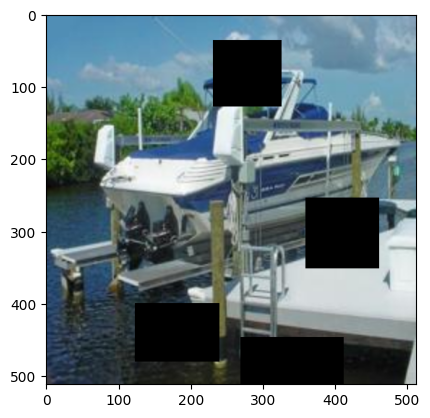

In [50]:
x,y,m = train_dataset[0]
x.shape, y.shape

plt.imshow(x.permute(1,2,0))
# plt.imshow(y.permute(1,2,0))

In [59]:
len(next(iter(train_dataloader)))

3

# MODEL MAKING

In [18]:
from torch.nn import Conv2d
import torch.nn.functional as F
# from pdb import set_trace as stx
import numbers
from einops import rearrange

device = "cuda" if torch.cuda.is_available() else "cpu"
## Feed-Forward Network (FFN)
############# HINT
def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')


def to_4d(x, h, w):
    return rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)


class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma + 1e-5) * self.weight


class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma + 1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type == 'BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim * ffn_expansion_factor)

        self.project_in = nn.Conv2d(dim, hidden_features * 2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features * 2, hidden_features * 2, kernel_size=3, stride=1, padding=1,
                                groups=hidden_features * 2, bias=bias)


        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)


    def forward(self, x):
        x = self.project_in(x)

        x1, x2 = self.dwconv(x).chunk(2, dim=1)

        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x

## Squeeze-and-Channel Attention Layer (SCAL)
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        #### Channel branch
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim * 3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim * 3, dim * 3, kernel_size=3, stride=1, padding=1, groups=dim * 3, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)


        #### Spatial branch
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3,stride=1,padding=1,bias=True),
            LayerNorm(dim, 'WithBias'),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, kernel_size=3,stride=1,padding=1,bias=True),
            LayerNorm(dim, 'WithBias'),
            nn.ReLU(inplace=True)
        )
        self.upsample = nn.Upsample(scale_factor=2)
        ##########

    def forward(self, x):
        #### Channel branch
        b, c, h, w = x.shape

        qkv = self.qkv_dwconv(self.qkv(x))
        q, k, v = qkv.chunk(3, dim=1)

        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = (attn @ v)

        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)

        #### Spatial branch
        y = self.avg_pool(x)
        y = self.conv(y)
        y = self.upsample(y)
        out = y * out
        ###########

        out = self.project_out(out)
        return out

########### Sandwich Block
class SandwichBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_expansion_factor, bias, LayerNorm_type):
        super(SandwichBlock, self).__init__()


        self.norm1_1 = LayerNorm(dim, LayerNorm_type).to(device)
        self.ffn1 = FeedForward(dim, ffn_expansion_factor, bias).to(device)

        self.norm1 = LayerNorm(dim, LayerNorm_type).to(device)

        self.attn = Attention(dim, num_heads, bias).to(device)

        self.norm2 = LayerNorm(dim, LayerNorm_type).to(device)

        self.ffn = FeedForward(dim, ffn_expansion_factor, bias).to(device)

    def forward(self, x):

        x = x + self.ffn1(self.norm1_1(x))
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))

        return x


## Gated Embedding layer
class GatedEmb(nn.Module):
    def __init__(self, in_c=4, embed_dim=48, bias=False): # for some time set 3=> 4
        super(GatedEmb, self).__init__()

        self.gproj1 = nn.Conv2d(in_c, embed_dim*2, kernel_size=3,stride=1,padding=1,bias=bias).to(device)


    def forward(self, x):
        #x = self.proj(x)
        x = self.gproj1(x)
        x1, x2 = x.chunk(2, dim=1)

        x = F.gelu(x1) * x2

        return x


## Mask-aware Pixel-Shuffle Down-Sampling (MPD)
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat // 2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelUnshuffle(2)).to(device)

        self.body2 = nn.Sequential(nn.PixelUnshuffle(2)).to(device)


        self.proj = nn.Conv2d(n_feat * 4, n_feat * 2, kernel_size=3, stride=1, padding=1, groups=n_feat * 2, bias=False).to(device)
    def forward(self, x, mask):

        out = self.body(x)
        out_mask = self.body2(mask)
        b,n,h,w = out.shape
        t = torch.zeros((b,2*n,h,w)).to(device)
        for i in range(n):
            t[:,2*i,:,:] = out[:,i,:,:]
        for i in range(n):
            if i <= 3:
                t[:,2*i+1,:,:] = out_mask[:,i,:,:]
            else:
                t[:,2*i+1,:,:] = out_mask[:,(i%4),:,:]

        return self.proj(t)



class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat * 2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelShuffle(2)).to(device)

    def forward(self, x, mask):
        return self.body(x)


##---------- HINT -----------------------
class HINT(nn.Module):
    def __init__(self,
                 inp_channels=4,
                 out_channels=3,
                 dim=48,
                 num_blocks=[4, 6, 6, 8],
                 heads=[1, 2, 4, 8],
                 ffn_expansion_factor=2.66,
                 bias=False,
                 LayerNorm_type='WithBias',  ## Other option 'BiasFree'
                 ):

        super(HINT, self).__init__()

        self.patch_embed = GatedEmb(inp_channels, dim)

        self.encoder_level1 = nn.Sequential(*[
            SandwichBlock(dim=dim, num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias,
                             LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])

        self.down1_2 = Downsample(dim)  ## From Level 1 to Level 2
        self.encoder_level2 = nn.Sequential(*[
            SandwichBlock(dim=int(dim * 2 ** 1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])

        self.down2_3 = Downsample(int(dim * 2 ** 1))  ## From Level 2 to Level 3
        self.encoder_level3 = nn.Sequential(*[
            SandwichBlock(dim=int(dim * 2 ** 2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])

        self.down3_4 = Downsample(int(dim * 2 ** 2))  ## From Level 3 to Level 4
        self.latent = nn.Sequential(*[
            SandwichBlock(dim=int(dim * 2 ** 3), num_heads=heads[3], ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[3])]).to(device)

        self.up4_3 = Upsample(int(dim * 2 ** 3))  ## From Level 4 to Level 3
        self.reduce_chan_level3 = nn.Conv2d(int(dim * 2 ** 3), int(dim * 2 ** 2), kernel_size=1, bias=bias).to(device)
        self.decoder_level3 = nn.Sequential(*[
            SandwichBlock(dim=int(dim * 2 ** 2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])

        self.up3_2 = Upsample(int(dim * 2 ** 2))  ## From Level 3 to Level 2
        self.reduce_chan_level2 = nn.Conv2d(int(dim * 2 ** 2), int(dim * 2 ** 1), kernel_size=1, bias=bias).to(device)
        self.decoder_level2 = nn.Sequential(*[
            SandwichBlock(dim=int(dim * 2 ** 1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])

        self.up2_1 = Upsample(int(dim * 2 ** 1))  ## From Level 2 to Level 1  (NO 1x1 conv to reduce channels)

        self.decoder_level1 = nn.Sequential(*[
            SandwichBlock(dim=int(dim * 2 ** 1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])


        self.output = nn.Sequential(nn.Conv2d(int(dim * 2 ** 1), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)
                                    )

    def forward(self, inp_img, mask_whole):  #, mask_half, mask_quarter,mask_tiny

        inp_enc_level1 = self.patch_embed(torch.cat((inp_img,mask_whole),dim=1))
        # print(f"SHAPE AFTER PATCH EMBED : {inp_enc_level1.shape}")

        out_enc_level1 = self.encoder_level1(inp_enc_level1)
        # print(f"SHAPE AFTER ENCODER LEVEL 1 : {out_enc_level1.shape}")

        inp_enc_level2 = self.down1_2(out_enc_level1,mask_whole)
        # print(f"SHAPE AFTER downsample : {inp_enc_level2.shape}")

        out_enc_level2 = self.encoder_level2(inp_enc_level2)
        # print(f"SHAPE AFTER ENCODER LEVEL 2 : {out_enc_level2.shape}")


        mask_half = F.interpolate(mask_whole, scale_factor=0.5, mode='nearest')
        inp_enc_level3 = self.down2_3(out_enc_level2,mask_half)
        out_enc_level3 = self.encoder_level3(inp_enc_level3)
        # print("ENODER LEVEL 3 DONE")

        mask_quarter = F.interpolate(mask_half, scale_factor=0.5, mode='nearest')
        inp_enc_level4 = self.down3_4(out_enc_level3,mask_quarter)
        # print("ENODER LEVEL 4 DONE")

        latent = self.latent(inp_enc_level4)

        mask_tiny = F.interpolate(mask_quarter, scale_factor=0.5, mode='nearest')
        inp_dec_level3 = self.up4_3(latent,mask_tiny)
        inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)

        inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)
        out_dec_level3 = self.decoder_level3(inp_dec_level3)
        # print("DECODER LEVEL 3 DONE")

        inp_dec_level2 = self.up3_2(out_dec_level3,mask_quarter)
        inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)

        inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)
        out_dec_level2 = self.decoder_level2(inp_dec_level2)
        # print("DECODER LEVEL 2 DONE")

        inp_dec_level1 = self.up2_1(out_dec_level2,mask_half)
        inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)

        out_dec_level1 = self.decoder_level1(inp_dec_level1)

        out_dec_level1 = self.output(out_dec_level1)

        out_dec_level1 = (torch.tanh(out_dec_level1) + 1) / 2
        # print("OUTPUT DONE")
        return out_dec_level1



In [19]:
# thisone is from yonocs
pi = 3.141592653589793

class RGB_HVI(nn.Module):
    def __init__(self):
        super(RGB_HVI, self).__init__()
        self.density_k = torch.nn.Parameter(torch.full([1],0.2)) # k is reciprocal to the paper mentioned
        self.gated = False
        self.gated2= False
        self.alpha = 1.0
        self.this_k = 0

    def HVIT(self, img):
        eps = 1e-8
        device = img.device
        dtypes = img.dtype
        hue = torch.Tensor(img.shape[0], img.shape[2], img.shape[3]).to(device).to(dtypes)
        value = img.max(1)[0].to(dtypes)
        img_min = img.min(1)[0].to(dtypes)
        hue[img[:,2]==value] = 4.0 + ( (img[:,0]-img[:,1]) / (value - img_min + eps)) [img[:,2]==value]
        hue[img[:,1]==value] = 2.0 + ( (img[:,2]-img[:,0]) / (value - img_min + eps)) [img[:,1]==value]
        hue[img[:,0]==value] = (0.0 + ((img[:,1]-img[:,2]) / (value - img_min + eps)) [img[:,0]==value]) % 6

        hue[img.min(1)[0]==value] = 0.0
        hue = hue/6.0

        saturation = (value - img_min ) / (value + eps )
        saturation[value==0] = 0

        hue = hue.unsqueeze(1)
        saturation = saturation.unsqueeze(1)
        value = value.unsqueeze(1)

        k = self.density_k
        self.this_k = k.item()

        color_sensitive = ((value * 0.5 * pi).sin() + eps).pow(k)
        cx = (2.0 * pi * hue).cos()
        cy = (2.0 * pi * hue).sin()
        X = color_sensitive * saturation * cx
        Y = color_sensitive * saturation * cy
        Z = value
        xyz = torch.cat([X, Y, Z],dim=1)
        return xyz

    def PHVIT(self, img):
        eps = 1e-8
        H,V,I = img[:,0,:,:],img[:,1,:,:],img[:,2,:,:]

        # clip
        H = torch.clamp(H,-1,1)
        V = torch.clamp(V,-1,1)
        I = torch.clamp(I,0,1)

        v = I
        k = self.this_k
        color_sensitive = ((v * 0.5 * pi).sin() + eps).pow(k)
        H = (H) / (color_sensitive + eps)
        V = (V) / (color_sensitive + eps)
        H = torch.clamp(H,-1,1)
        V = torch.clamp(V,-1,1)
        h = torch.atan2(V,H) / (2*pi)
        h = h%1
        s = torch.sqrt(H**2 + V**2)

        if self.gated:
            s = s * 1.3

        s = torch.clamp(s,0,1)
        v = torch.clamp(v,0,1)

        r = torch.zeros_like(h)
        g = torch.zeros_like(h)
        b = torch.zeros_like(h)

        hi = torch.floor(h * 6.0)
        f = h * 6.0 - hi
        p = v * (1. - s)
        q = v * (1. - (f * s))
        t = v * (1. - ((1. - f) * s))

        hi0 = hi==0
        hi1 = hi==1
        hi2 = hi==2
        hi3 = hi==3
        hi4 = hi==4
        hi5 = hi==5

        r[hi0] = v[hi0]
        g[hi0] = t[hi0]
        b[hi0] = p[hi0]

        r[hi1] = q[hi1]
        g[hi1] = v[hi1]
        b[hi1] = p[hi1]

        r[hi2] = p[hi2]
        g[hi2] = v[hi2]
        b[hi2] = t[hi2]

        r[hi3] = p[hi3]
        g[hi3] = q[hi3]
        b[hi3] = v[hi3]

        r[hi4] = t[hi4]
        g[hi4] = p[hi4]
        b[hi4] = v[hi4]

        r[hi5] = v[hi5]
        g[hi5] = p[hi5]
        b[hi5] = q[hi5]

        r = r.unsqueeze(1)
        g = g.unsqueeze(1)
        b = b.unsqueeze(1)
        rgb = torch.cat([r, g, b], dim=1)
        if self.gated2:
            rgb = rgb * self.alpha
        return rgb

In [ ]:
rgb = RGB_HVI()
rnd = torch.rand(size = (1,3,256,256))
hvit_rnd = rgb.HVIT(rnd)                # hue , value , intensity    -- 3rd channel have the intensity i.e. 2 dimension and we will use intensity and hvi (hv will ot be used alone
original = rgb.PHVIT(hvit_rnd)

In [ ]:
hvit_rnd.shape, original.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

In [ ]:
# plt.subplot(1,2,1)
# plt.imshow(hvit_rnd[:,:2,...].detach().squeeze(0).permute(0,1,2))
# plt.axis("off")

# plt.subplot(1,2,2)
# plt.imshow(hvit_rnd[:,2,...].detach().squeeze(0).permute(0,1,2))
# plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

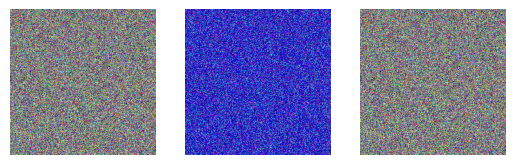

In [ ]:
plt.subplot(1,3,1)
plt.imshow(rnd.squeeze().permute(1,2,0))
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(hvit_rnd.detach().squeeze(0).permute(1,2,0))
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(original.detach().squeeze(0).permute(1,2,0))
plt.axis("off")

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from einops import rearrange

# class LayerNorm(nn.Module):
#     r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
#     The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
#     shape (batch_size, height, width, channels) while channels_first corresponds to inputs
#     with shape (batch_size, channels, height, width).
#     """
#     def __init__(self, normalized_shape, eps=1e-6, data_format="channels_first"):
#         super().__init__()
#         self.weight = nn.Parameter(torch.ones(normalized_shape))
#         self.bias = nn.Parameter(torch.zeros(normalized_shape))
#         self.eps = eps
#         self.data_format = data_format
#         if self.data_format not in ["channels_last", "channels_first"]:
#             raise NotImplementedError
#         self.normalized_shape = (normalized_shape, )

#     def forward(self, x):
#         if self.data_format == "channels_last":
#             return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
#         elif self.data_format == "channels_first":
#             u = x.mean(1, keepdim=True)
#             s = (x - u).pow(2).mean(1, keepdim=True)
#             print(self.eps)
#             x = (x - u) / torch.sqrt(s + self.eps)
#             x = self.weight[:, None, None] * x + self.bias[:, None, None]
#             return x

class NormDownsample(nn.Module):
    def __init__(self,in_ch,out_ch,scale=0.5,use_norm=False):
        super(NormDownsample, self).__init__()
        self.use_norm=use_norm
        if self.use_norm:
            self.norm=LayerNorm(out_ch)
        self.prelu = nn.PReLU()
        self.down = nn.Sequential(
            nn.Conv2d(in_ch, out_ch,kernel_size=3,stride=1, padding=1, bias=False),
            nn.UpsamplingBilinear2d(scale_factor=scale))
    def forward(self, x):
        x = self.down(x)
        x = self.prelu(x)
        if self.use_norm:
            x = self.norm(x)
            return x
        else:
            return x

class NormUpsample(nn.Module):
    def __init__(self, in_ch,out_ch,scale=2,use_norm=False):
        super(NormUpsample, self).__init__()
        self.use_norm=use_norm
        if self.use_norm:
            self.norm=LayerNorm(out_ch)
        self.prelu = nn.PReLU()
        self.up_scale = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,kernel_size=3,stride=1, padding=1, bias=False),
            nn.UpsamplingBilinear2d(scale_factor=scale))
        self.up = nn.Conv2d(out_ch*2,out_ch,kernel_size=1,stride=1, padding=0, bias=False)

    def forward(self, x,y):
        x = self.up_scale(x)
        x = torch.cat([x, y],dim=1)
        x = self.up(x)
        x = self.prelu(x)
        if self.use_norm:
            return self.norm(x)
        else:
            return x


In [ ]:
"""
1. first divide the img to hv and i part
2. Then pass the hv and i to our hint model and at end concatenate both
3. Then perform reverse hvit


"""

'\n1. first divide the img to hv and i part\n2. Then pass the hv and i to our hint model and at end concatenate both\n3. Then perform reverse hvit\n\n\n'

# TRAINING PART

In [34]:
import os
import torch
from collections import OrderedDict
from torch import nn as nn
from torchvision.models import vgg as vgg

class Registry():
    """
    The registry that provides name -> object mapping, to support third-party
    users' custom modules.

    To create a registry (e.g. a backbone registry):

    .. code-block:: python

        BACKBONE_REGISTRY = Registry('BACKBONE')

    To register an object:

    .. code-block:: python

        @BACKBONE_REGISTRY.register()
        class MyBackbone():
            ...

    Or:

    .. code-block:: python

        BACKBONE_REGISTRY.register(MyBackbone)
    """

    def __init__(self, name):
        """
        Args:
            name (str): the name of this registry
        """
        self._name = name
        self._obj_map = {}

    def _do_register(self, name, obj):
        assert (name not in self._obj_map), (f"An object named '{name}' was already registered "
                                             f"in '{self._name}' registry!")
        self._obj_map[name] = obj

    def register(self, obj=None):
        """
        Register the given object under the the name `obj.__name__`.
        Can be used as either a decorator or not.
        See docstring of this class for usage.
        """
        if obj is None:
            # used as a decorator
            def deco(func_or_class):
                name = func_or_class.__name__
                self._do_register(name, func_or_class)
                return func_or_class

            return deco

        # used as a function call
        name = obj.__name__
        self._do_register(name, obj)

    def get(self, name):
        ret = self._obj_map.get(name)
        if ret is None:
            raise KeyError(f"No object named '{name}' found in '{self._name}' registry!")
        return ret

    def __contains__(self, name):
        return name in self._obj_map

    def __iter__(self):
        return iter(self._obj_map.items())

    def keys(self):
        return self._obj_map.keys()


DATASET_REGISTRY = Registry('dataset')
ARCH_REGISTRY = Registry('arch')
MODEL_REGISTRY = Registry('model')
LOSS_REGISTRY = Registry('loss')
METRIC_REGISTRY = Registry('metric')

VGG_PRETRAIN_PATH = 'experiments/pretrained_models/vgg19-dcbb9e9d.pth'
NAMES = {
    'vgg11': [
        'conv1_1', 'relu1_1', 'pool1', 'conv2_1', 'relu2_1', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2',
        'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2',
        'pool5'
    ],
    'vgg13': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'pool5'
    ],
    'vgg16': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2',
        'relu4_2', 'conv4_3', 'relu4_3', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3',
        'pool5'
    ],
    'vgg19': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3', 'conv4_1',
        'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4', 'conv5_1', 'relu5_1',
        'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    ]
}


def insert_bn(names):
    """Insert bn layer after each conv.

    Args:
        names (list): The list of layer names.

    Returns:
        list: The list of layer names with bn layers.
    """
    names_bn = []
    for name in names:
        names_bn.append(name)
        if 'conv' in name:
            position = name.replace('conv', '')
            names_bn.append('bn' + position)
    return names_bn


@ARCH_REGISTRY.register()
class VGGFeatureExtractor(nn.Module):
    """VGG network for feature extraction.

    In this implementation, we allow users to choose whether use normalization
    in the input feature and the type of vgg network. Note that the pretrained
    path must fit the vgg type.

    Args:
        layer_name_list (list[str]): Forward function returns the corresponding
            features according to the layer_name_list.
            Example: {'relu1_1', 'relu2_1', 'relu3_1'}.
        vgg_type (str): Set the type of vgg network. Default: 'vgg19'.
        use_input_norm (bool): If True, normalize the input image. Importantly,
            the input feature must in the range [0, 1]. Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
            Default: False.
        requires_grad (bool): If true, the parameters of VGG network will be
            optimized. Default: False.
        remove_pooling (bool): If true, the max pooling operations in VGG net
            will be removed. Default: False.
        pooling_stride (int): The stride of max pooling operation. Default: 2.
    """

    def __init__(self,
                 layer_name_list,
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=False,
                 requires_grad=False,
                 remove_pooling=False,
                 pooling_stride=2):
        super(VGGFeatureExtractor, self).__init__()

        self.layer_name_list = layer_name_list
        self.use_input_norm = use_input_norm
        self.range_norm = range_norm

        self.names = NAMES[vgg_type.replace('_bn', '')]
        if 'bn' in vgg_type:
            self.names = insert_bn(self.names)

        # only borrow layers that will be used to avoid unused params
        max_idx = 0
        for v in layer_name_list:
            idx = self.names.index(v)
            if idx > max_idx:
                max_idx = idx

        if os.path.exists(VGG_PRETRAIN_PATH):
            vgg_net = getattr(vgg, vgg_type)(pretrained=False)
            state_dict = torch.load(VGG_PRETRAIN_PATH, map_location=lambda storage, loc: storage)
            vgg_net.load_state_dict(state_dict)
        else:
            vgg_net = getattr(vgg, vgg_type)(pretrained=True)

        features = vgg_net.features[:max_idx + 1]

        modified_net = OrderedDict()
        for k, v in zip(self.names, features):
            if 'pool' in k:
                # if remove_pooling is true, pooling operation will be removed
                if remove_pooling:
                    continue
                else:
                    # in some cases, we may want to change the default stride
                    modified_net[k] = nn.MaxPool2d(kernel_size=2, stride=pooling_stride)
            else:
                modified_net[k] = v

        self.vgg_net = nn.Sequential(modified_net).to(device)

        if not requires_grad:
            self.vgg_net.eval()
            for param in self.parameters():
                param.requires_grad = False
        else:
            self.vgg_net.train()
            for param in self.parameters():
                param.requires_grad = True

        if self.use_input_norm:
            # the mean is for image with range [0, 1]
            self.register_buffer('mean', torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device))
            # the std is for image with range [0, 1]
            self.register_buffer('std', torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device))

    def forward(self, x):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        if self.range_norm:
            x = (x + 1) / 2
        if self.use_input_norm:
            x = (x - self.mean) / self.std
        output = {}

        for key, layer in self.vgg_net._modules.items():
            x = layer(x)
            if key in self.layer_name_list:
                output[key] = x.clone()

        return output

In [41]:
#1. LOSS FUNCTION = STYLE LOSS + PERCEPTUAL LOSS + ADVERSARIAL LOSS + L1LOSS + EDGE LOSS
# CALCULATE LOSS ON BOTH FINAL IMAGE AND HVI FORM IMAGE I.E. ONE BEFORE CONVERION TO RGB DIMENSION
# ALSO I DONTTHINK THAT THERE IS ANY NEED TO TRAIN THE TRANSFORMER
# from loss.vgg_arch import VGGFeatureExtractor, Registry

# def adversarial_loss():                      FOR TIME BEING IM SKIPPING DISCRIMNATOR LOSS
#   pass

import torch.nn.functional as F

class StyleLoss(nn.Module):

    def __init__(self):
        super(StyleLoss, self).__init__()

    def gram_matrix(self,input):
      a, b, c, d = input.size()  # a=batch size(=1)
      # b=number of feature maps
      # (c,d)=dimensions of a f. map (N=c*d)

      features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

      G = torch.mm(features, features.t())  # compute the gram product

      # we 'normalize' the values of the gram matrix
      # by dividing by the number of element in each feature maps.
      return G.div(a * b * c * d)

    def forward(self, input, target1):
        G = self.gram_matrix(input)
        target = self.gram_matrix(target1).detach()
        self.loss = F.mse_loss(G, target)
        return self.loss

class PerceptualLoss(nn.Module):
    """Perceptual loss with commonly used style loss.

    Args:
        layer_weights (dict): The weight for each layer of vgg feature.
            Here is an example: {'conv5_4': 1.}, which means the conv5_4
            feature layer (before relu5_4) will be extracted with weight
            1.0 in calculting losses.
        vgg_type (str): The type of vgg network used as feature extractor.
            Default: 'vgg19'.
        use_input_norm (bool):  If True, normalize the input image in vgg.
            Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
            Default: False.
      """

    def __init__(self,
                 layer_weights = {'conv1_2': 1, 'conv2_2': 1,'conv3_4': 1,'conv4_4': 1},
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=True):
        super(PerceptualLoss, self).__init__()
        self.layer_weights = layer_weights
        self.vgg = VGGFeatureExtractor(
            layer_name_list=list(layer_weights.keys()),
            vgg_type=vgg_type,
            use_input_norm=use_input_norm,
            range_norm=range_norm)

        self.criterion = torch.nn.L1Loss()

    def forward(self, x, gt):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).
            gt (Tensor): Ground-truth tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        # extract vgg features
        x_features = self.vgg(x)
        gt_features = self.vgg(gt.detach())

        # calculate perceptual loss
        percep_loss = 0
        for k in x_features.keys():
            percep_loss += self.criterion(x_features[k], gt_features[k]) * self.layer_weights[k]

        return percep_loss


# def l1_loss():   -> take direct from premade
#   pass

class EdgeLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(EdgeLoss, self).__init__()
        k = torch.Tensor([[.05, .25, .4, .25, .05]])
        self.kernel = torch.matmul(k.t(),k).unsqueeze(0).repeat(3,1,1,1).to(device)

    def conv_gauss(self, img):
        n_channels, _, kw, kh = self.kernel.shape
        img = F.pad(img, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
        return F.conv2d(img, self.kernel, groups=n_channels)

    def laplacian_kernel(self, current):
        filtered    = self.conv_gauss(current)
        down        = filtered[:,:,::2,::2]
        new_filter  = torch.zeros_like(filtered)
        new_filter[:,:,::2,::2] = down*4
        filtered    = self.conv_gauss(new_filter)
        diff = current - filtered
        return diff

    def forward(self, x, y):
        loss = F.mse_loss(self.laplacian_kernel(x), self.laplacian_kernel(y))
        return loss

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.edge_loss = EdgeLoss()
        self.mse_loss = nn.MSELoss()  # l1 loss
        self.style_loss = StyleLoss()
        self.perceptual_loss = PerceptualLoss()

    def forward(self, gen_img, gt_img):
        edge_loss_value = self.edge_loss(gen_img, gt_img)
        mse_loss_value = self.mse_loss(gen_img, gt_img)
        style_loss_value = self.style_loss(gen_img, gt_img)
        perceptual_loss_value = self.perceptual_loss(gen_img, gt_img)
        total_loss = edge_loss_value + mse_loss_value + style_loss_value + perceptual_loss_value
        return total_loss


In [42]:
device = "cpu"
loss_fn = CombinedLoss()

img = torch.randn(size = (1,3,256,256))
loss_fn(img,img)    # so loss function is working

tensor(0.)

In [51]:
# OPTIMZER AND OTHER SETTINGS FOR TRAINING
from torch.optim import Adam

loss_fn = CombinedLoss()
rgb_to_hvi = RGB_HVI()

model = HINT(inp_channels = 4)
optimizer = Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

NUM_EPOCHS = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

print(type(model))
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = 0
  model.train()
  for num,(x,y,m) in enumerate(train_dataloader):
    x,y, m = x.to(torch.float).to(device), y.to(torch.float).to(device), m.to(torch.float).to(device).unsqueeze(1)
    # print(x.shape, y.shape, m.shape)
    # m = F.conv2d(m.unsqueeze(1), torch.ones(3,1,3,3).to(device), padding = 1)
    # print(x.shape, y.shape, m.shape)
    # x_hvi,y_hvi,m_hvi = rgb_to_hvi.HVIT(x), rgb_to_hvi.HVIT(y), rgb_to_hvi.HVIT(m)
    x_hvi,y_hvi = rgb_to_hvi.HVIT(x), rgb_to_hvi.HVIT(y)

    pred_hvi = model(x_hvi, m)
    pred = rgb_to_hvi.PHVIT(pred_hvi)

    loss_hvi = loss_fn(pred_hvi, y_hvi) # loss for hvi color space
    loss_rgb = loss_fn(pred, y)  # for RGB color space
    total_loss = loss_hvi + loss_rgb
    train_loss += total_loss.item()

    # train_loss += loss_hvi.item()
    # train_loss += loss_rgb.item()

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

  test_loss = 0
  model.eval()
  with torch.inference_mode():
    for num ,(x,y,m) in enumerate(test_dataloader):
      x,y,m = x.to(torch.float).to(device), y.to(torch.float).to(device), m.to(torch.float).to(device).unsqueeze(1)
      x_hvi,y_hvi = rgb_to_hvi.HVIT(x), rgb_to_hvi.HVIT(y)

      pred_hvi = model(x_hvi, m)
      pred = rgb_to_hvi.PHVIT(pred_hvi)

      loss_hvi = loss_fn(pred_hvi, y_hvi) # loss for hvi color space
      loss_rgb = loss_fn(pred, y)

      total_loss = loss_hvi + loss_rgb
      test_loss += total_loss.item()

  test_loss /= len(test_dataloader)
  train_loss /= len(train_dataloader)

  if epoch%1 == 0:
    print(f'\nepoch : {epoch} || train loss : {train_loss} || test loss : {test_loss}')


<class '__main__.HINT'>


  0%|          | 0/5 [00:00<?, ?it/s]

# THIS MISGHT HELP IN TRAINING

In [ ]:
import random
def create_mask(width, height, mask_width, mask_height, x=None, y=None):
    mask = np.zeros((height, width))
    mask_x = x if x is not None else random.randint(0, width - mask_width)
    mask_y = y if y is not None else random.randint(0, height - mask_height)
    mask[mask_y:mask_y + mask_height, mask_x:mask_x + mask_width] = 1
    return mask

In [ ]:
sample_img = torch.rand(size = (1,3,256,256))
mask = torch.tensor(create_mask(256,256,128,128)).unsqueeze(0).unsqueeze(0)

print(f"SHAPE OF SAMPLE IMAGE : {sample_img.shape} || SHAPE OF MASK : {mask.shape}")

# this is the module which do the trsnaformations
rgb = RGB_HVI()

hvit_rnd = rgb.HVIT(sample_img)

# here i need to perform the HINT operarions
hint_model = HINT(inp_channels = 4)       # shape after concatentaion as 3 channels of image and 1 channel of mask when combined results in 4
out = hint_model(hvit_rnd.float().to(device),mask.float().to(device))  #, mask_whole, mask_half, mask_quarter,mask_tiny

# after 3,4 encoder hike

original = rgb.PHVIT(out.to("cpu"))

SHAPE OF SAMPLE IMAGE : torch.Size([1, 3, 256, 256]) || SHAPE OF MASK : torch.Size([1, 1, 256, 256])
SHAPE AFTER PATCH EMBED : torch.Size([1, 48, 256, 256])
SHAPE AFTER ENCODER LEVEL 1 : torch.Size([1, 48, 256, 256])
SHAPE AFTER downsample : torch.Size([1, 96, 128, 128])
SHAPE AFTER ENCODER LEVEL 2 : torch.Size([1, 96, 128, 128])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


ENODER LEVEL 3 DONE
ENODER LEVEL 4 DONE
DECODER LEVEL 3 DONE
DECODER LEVEL 2 DONE


OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 

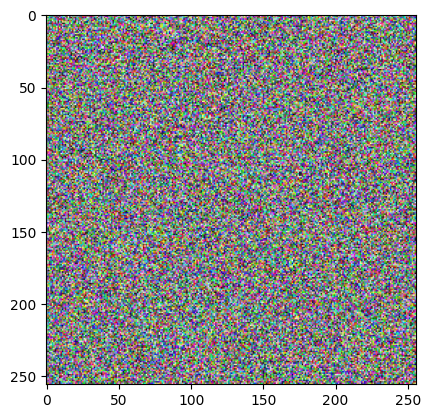

In [ ]:
# original.shape
# plt.imshow(sample_img.detach().squeeze(0).permute(1,2,0))
# plt.imshow(original.detach().squeeze(0).permute(1,2,0))

# EXTRA - WORKINGS

In [ ]:
## Mask-aware Pixel-Shuffle Down-Sampling (MPD)
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat // 2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelUnshuffle(2))

        self.body2 = nn.Sequential(nn.PixelUnshuffle(2))


        self.proj = nn.Conv2d(n_feat * 4, n_feat * 2, kernel_size=3, stride=1, padding=1, groups=n_feat * 2, bias=False)
    def forward(self, x, mask):

        out = self.body(x)
        out_mask = self.body2(mask)
        b,n,h,w = out.shape
        t = torch.zeros((b,2*n,h,w)).to(device)
        for i in range(n):
            t[:,2*i,:,:] = out[:,i,:,:]
        for i in range(n):
            if i <= 3:
                t[:,2*i+1,:,:] = out_mask[:,i,:,:]
            else:
                t[:,2*i+1,:,:] = out_mask[:,(i%4),:,:]

        return self.proj(t)

ddd = Downsample(96)
res = ddd(torch.rand(size = (1,96,128,128)),torch.rand(size = (1,1,128,128)))
res.shape

torch.Size([1, 192, 64, 64])

In [ ]:
48*2**2

192

In [ ]:
mask.shape, mask.dtype

(torch.Size([1, 1, 256, 256]), torch.float64)

In [ ]:
c = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0, bias=False)
gg = c(mask.float())
gg.shape

torch.Size([1, 1, 254, 254])

In [ ]:
import torch
import torch.nn.functional as F

# Assuming 'mask' is your input tensor with shape (1, 1, 256, 256)

# Resize the input tensor to shape (1, 1, 128, 128)
resized_mask = F.interpolate(mask, size=(64, 64), mode='nearest')

# Check the shape of the resized tensor
print(resized_mask.shape)  # Output: torch.Size([1, 1, 128, 128])


torch.Size([1, 1, 64, 64])


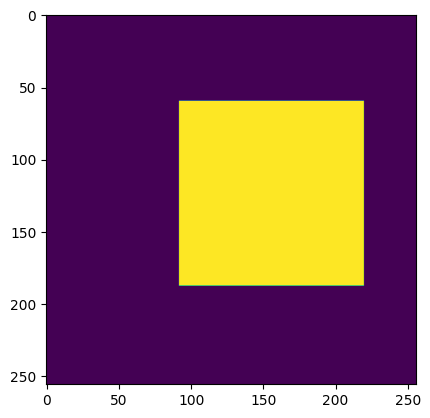

In [ ]:
plt.imshow(mask.squeeze(0).detach().permute(1,2,0).numpy())

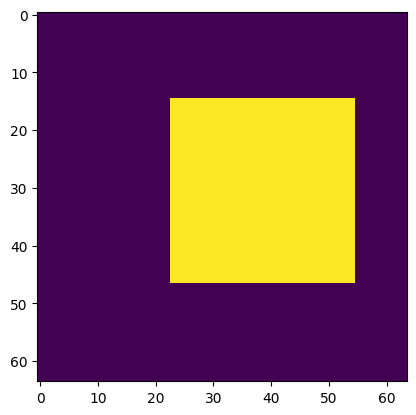

In [ ]:
plt.imshow(resized_mask.squeeze(0).detach().permute(1,2,0).numpy())